# Image Manipulation with skimage

This example builds a simple UI for performing basic image manipulation with [scikit-image](http://scikit-image.org/).

In [1]:
# Stdlib imports
from io import BytesIO

# Third-party libraries
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
import matplotlib as mpl
from skimage import data, filters, io, img_as_float

Let's load an image from scikit-image's collection, stored in the `data` module. These come back as regular numpy arrays:

In [2]:
i = img_as_float(data.coffee())
i.shape

(400, 600, 3)

Let's make a little utility function for displaying Numpy arrays with the IPython display protocol:

In [3]:
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    vmax = 255 if arr.dtype == 'uint8' else 1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

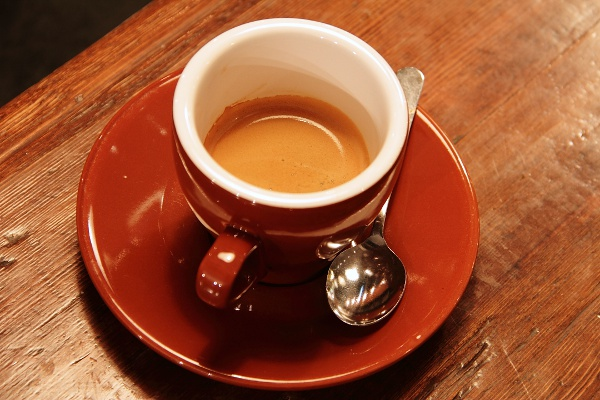

In [4]:
arr2img(i)

Now, let's create a simple "image editor" function, that allows us to blur the image or change its color balance:

In [5]:
def edit_image(image, sigma=0.1, R=1.0, G=1.0, B=1.0):
    new_image = filters.gaussian(image, sigma=sigma, multichannel=True)
    new_image[:,:,0] = R*new_image[:,:,0]
    new_image[:,:,1] = G*new_image[:,:,1]
    new_image[:,:,2] = B*new_image[:,:,2]
    return arr2img(new_image)

We can call this function manually and get a new image. For example, let's do a little blurring and remove all the red from the image:

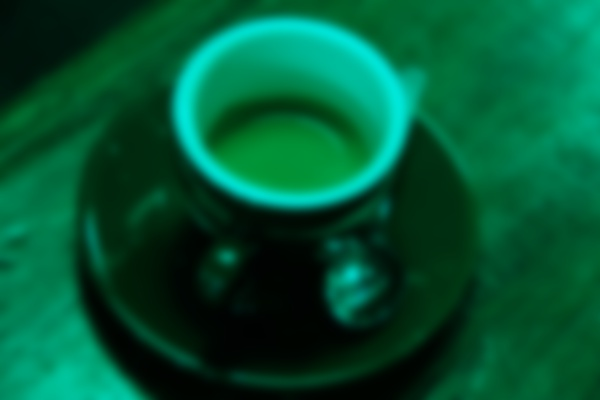

In [6]:
edit_image(i, sigma=5, R=0)

But it's a lot easier to explore what this function does by controlling each parameter interactively and getting immediate visual feedback. IPython's `ipywidgets` package lets us do that with a minimal amount of code:

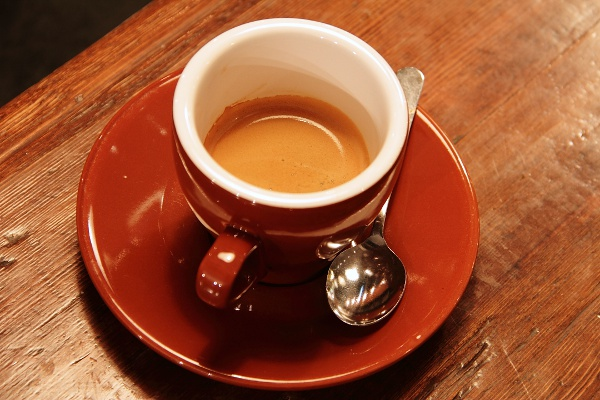

In [7]:
lims = (0.0,1.0,0.01)
interactive(edit_image, image=fixed(i), sigma=(0.0,10.0,0.1), R=lims, G=lims, B=lims)

# Browsing the scikit-image gallery, and editing grayscale and jpg images

The coffee cup isn't the only image that ships with scikit-image, the `data` module has others. Let's make a quick interactive explorer for this:

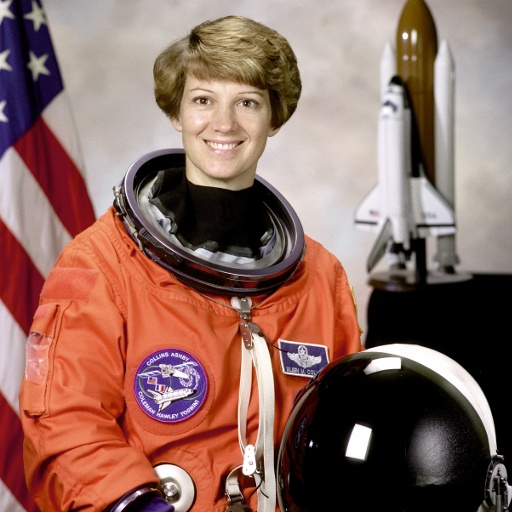

In [8]:
def choose_img(name):
    # Let's store the result in the global `img` that we can then use in our image editor below
    global img
    img = getattr(data, name)()
    return arr2img(img)

# Skip 'load' and 'lena', two functions that don't actually return images
interact(choose_img, name=sorted(set(data.__all__)-{'lena', 'load'}));

And now, let's update our editor to cope correctly with grayscale and color images, since some images in the scikit-image collection are grayscale.  For these, we ignore the red (R) and blue (B) channels, and treat 'G' as 'Grayscale':

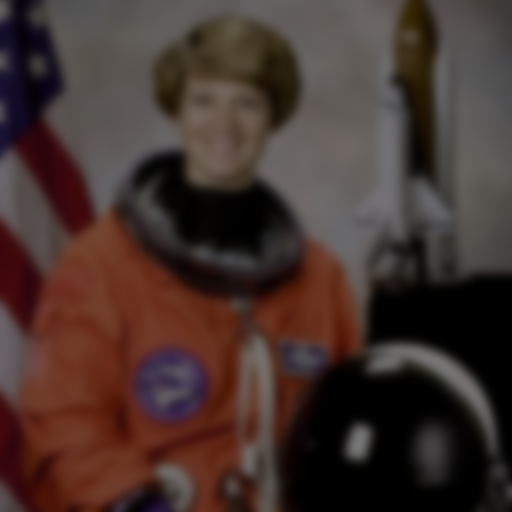

In [9]:
lims = (0.0, 1.0, 0.01)

def edit_image(image, sigma, R, G, B):
    new_image = filters.gaussian(image, sigma=sigma, multichannel=True)
    if new_image.ndim == 3:
        new_image[:,:,0] = R*new_image[:,:,0]
        new_image[:,:,1] = G*new_image[:,:,1]
        new_image[:,:,2] = B*new_image[:,:,2]
    else:
        new_image = G*new_image
    return arr2img(new_image)

interact(edit_image, image=fixed(img), sigma=(0.0, 10.0, 0.1), 
               R=lims, G=lims, B=lims);

## Python 3 only: Function annotations and unicode identifiers

In Python 3, we can use the new function annotation syntax to describe widgets for interact, as well as unicode names for variables such as sigma. Note how this syntax also lets us define default values for each control in a convenient (if slightly awkward looking) form: `var:descriptor=default`.

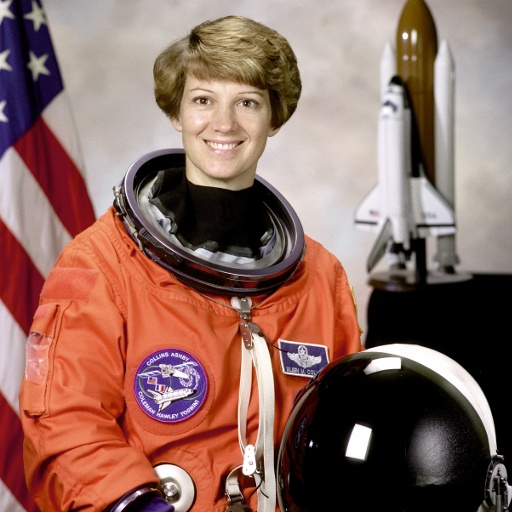

In [10]:
lims = (0.0, 1.0, 0.01)

@interact
def edit_image(image: fixed(img), σ:(0.0, 10.0, 0.1)=0, 
               R:lims=1.0, G:lims=1.0, B:lims=1.0):
    new_image = filters.gaussian(image, sigma=σ, multichannel=True)
    if new_image.ndim == 3:
        new_image[:,:,0] = R*new_image[:,:,0]
        new_image[:,:,1] = G*new_image[:,:,1]
        new_image[:,:,2] = B*new_image[:,:,2]
    else:
        new_image = G*new_image
    return arr2img(new_image)